In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect_maxv, causaleffect_maxv_linear, causaleffect_maxv_sp

Populating the interactive namespace from numpy and matplotlib


In [3]:
c = 0.99

t = 500

#nsims = 500
#N = 20
#fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)

nsims = 1
N = 19
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)

sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

In [4]:
params = ParamsLIF()
params_orig = ParamsLIF()
lif = LIF(params, t = t)

In [71]:
DeltaT = 2

tau_s = 0.2

p = 0.2
wmax = 20
wmin = 2

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

cost2 = np.zeros((N,N))
cost2_tmp = np.zeros((nsims,hs.shape[4]))

C_s1 = np.zeros((N, N))
C_s2 = np.zeros((N, N))
C_s1s1 = np.zeros((N, N))
C_s1s2 = np.zeros((N, N))
C_s2s2 = np.zeros((N, N))

C_s1_tmp = np.zeros((nsims,hs.shape[4]))
C_s2_tmp = np.zeros((nsims,hs.shape[4]))
C_s1s1_tmp = np.zeros((nsims,hs.shape[4]))
C_s1s2_tmp = np.zeros((nsims,hs.shape[4]))
C_s2s2_tmp = np.zeros((nsims,hs.shape[4]))

mu_s1 = np.zeros((N, N))
mu_s2 = np.zeros((N, N))
sigma_s1s1 = np.zeros((N, N))
sigma_s1s2 = np.zeros((N, N))
sigma_s2s2 = np.zeros((N, N))

mu_s1_tmp = np.zeros((nsims))
mu_s2_tmp = np.zeros((nsims))
sigma_s1s1_tmp = np.zeros((nsims))
sigma_s1s2_tmp = np.zeros((nsims))
sigma_s2s2_tmp = np.zeros((nsims))

# Original
#B1 = 3
#B2 = 300
#x = 1
#y = 0.12
#z = -0.3

#Used in paper
#B1 = 1
#B2 = 2
#x = .01
#y = 0.1
#z = 0

# A mix
B1 = 1
B2 = 2
x = 0.01
y = 0.1
z = 0

cost2_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

#C_s1_fun = lambda s1, s2: 2*B1*(B1*s1-x) + 4*B1*B2*np.multiply((B1*s1-y),(z+B2*s2 - B2*(B1*s1-y)**2))
#C_s2_fun = lambda s1, s2: 2*B2*(z + B2*s2 - B2*(B1*s1-y)**2)
#C_s1s1_fun = lambda s1, s2: 2*B1*B1 + 4*B1*B2*(z+B2*s2-B2*(B1*s1-y)**2) - 4*B1*B2*np.multiply(B1*s1-y, 2*B1*B2*(B1*s1-y))
#C_s1s2_fun = lambda s1, s2: 4*B2*B2*B1*(B1*s1-y)
#C_s2s2_fun = lambda s1, s2: 2*B2*B2

#OR what if we use the discrete operator instead?
C_s1_fun = lambda s1, s2: (B1*s1+B1*ds-x)**2 + (z+B2*s2 - B2*(B1*s1+B1*ds-y)**2)**2 - (B1*s1-x)**2 - (z+B2*s2 - B2*(B1*s1-y)**2)**2
C_s2_fun = lambda s1, s2: (z+B2*s2+B2*ds - B2*(B1*s1-y)**2)**2 - (z+B2*s2 - B2*(B1*s1-y)**2)**2
C_s1s1_fun = lambda s1, s2: 2*B1*B1 + 4*B1*B2*(z+B2*s2-B2*(B1*s1-y)**2) - 4*B1*B2*np.multiply(B1*s1-y, 2*B1*B2*(B1*s1-y))
C_s1s2_fun = lambda s1, s2: 4*B2*B2*B1*(B1*s1-y)
C_s2s2_fun = lambda s1, s2: 2*B2*B2

In [72]:
#Compute

#alpha1 = -30
#alpha2 = 20
#x = 2
#cost2_fun = lambda s1, s2: (alpha1*s1 + alpha2*s2 - x**2)**2

#Compute mean cost function numerically, so we can compare gradient with our result
for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_tmp[k,:] = cost2_fun(s1, s2)
            #Also compute mean of partial derivative terms
            C_s1_tmp[k,:] = C_s1_fun(s1, s2)
            C_s2_tmp[k,:] = C_s2_fun(s1, s2)
            C_s1s1_tmp[k,:] = C_s1s1_fun(s1, s2)
            C_s1s2_tmp[k,:] = C_s1s2_fun(s1, s2)
            C_s2s2_tmp[k,:] = C_s2s2_fun(s1, s2)
            #Also compute mean and covariance matrix of s1 and s2
            mu_s1_tmp[k] = np.mean(s1)
            mu_s2_tmp[k] = np.mean(s2)
            cov = np.cov(s1, s2)
            sigma_s1s1_tmp[k] = cov[0,0]
            sigma_s1s2_tmp[k] = cov[0,1]
            sigma_s2s2_tmp[k] = cov[1,1]

        cost2[i,j] = np.mean(cost2_tmp)
        C_s1[i,j] = np.mean(C_s1_tmp)
        C_s2[i,j] = np.mean(C_s2_tmp)
        C_s1s1[i,j] = np.mean(C_s1s1_tmp)
        C_s1s2[i,j] = np.mean(C_s1s2_tmp)
        C_s2s2[i,j] = np.mean(C_s2s2_tmp)

        mu_s1[i,j] = np.mean(mu_s1_tmp)
        mu_s2[i,j] = np.mean(mu_s2_tmp)
        sigma_s1s1[i,j] = np.mean(sigma_s1s1_tmp)
        sigma_s1s2[i,j] = np.mean(sigma_s1s2_tmp)
        sigma_s2s2[i,j] = np.mean(sigma_s2s2_tmp)
        

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18


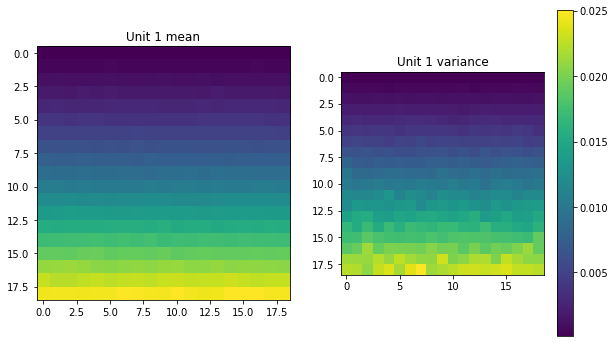

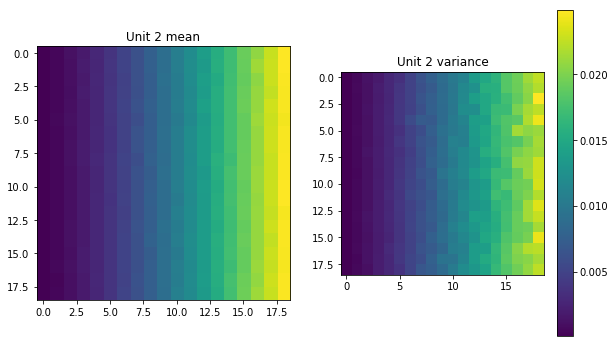

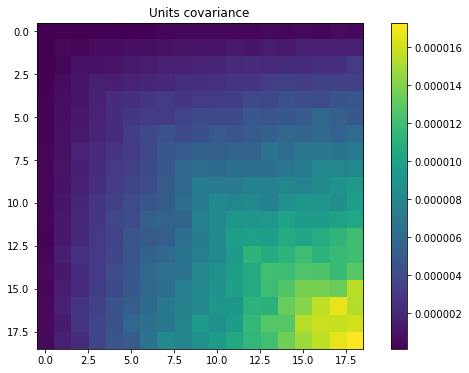

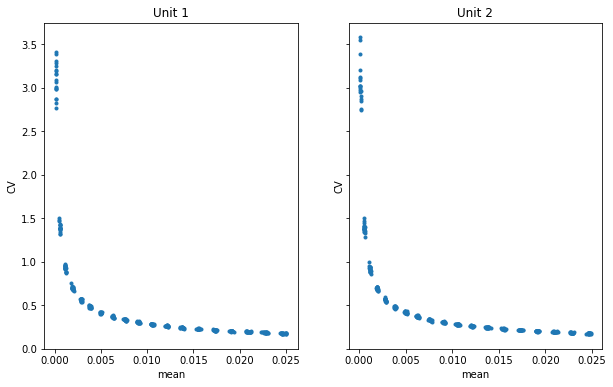

In [73]:
#Plot the mean and variance activity functions

#Unit 1
fig, (ax1, ax2) = plt.subplots(1,2)
a=ax1.imshow(mu_s1)
b=ax2.imshow(sigma_s1s1)
ax1.set_title('Unit 1 mean')
ax2.set_title('Unit 1 variance')
plt.colorbar(a)

#Unit 2
fig, (ax1, ax2) = plt.subplots(1,2)
a = ax1.imshow(mu_s2)
b = ax2.imshow(sigma_s2s2)
ax1.set_title('Unit 2 mean')
ax2.set_title('Unit 2 variance')
plt.colorbar(a)

fig, (ax1) = plt.subplots(1,1)
a = ax1.imshow(sigma_s1s2)
ax1.set_title('Units covariance')
plt.colorbar(a)

fig, (ax1,ax2) = plt.subplots(1,2, sharey = True)
ax1.plot(mu_s1.reshape((-1,1)), np.divide(np.sqrt(sigma_s1s1.reshape((-1,1))), mu_s1.reshape((-1,1))), '.')
ax1.set_title('Unit 1')
ax1.set_ylabel('CV')
ax1.set_xlabel('mean')
ax2.plot(mu_s2.reshape((-1,1)), np.divide(np.sqrt(sigma_s2s2.reshape((-1,1))), mu_s2.reshape((-1,1))), '.')
ax2.set_title('Unit 2')
ax2.set_ylabel('CV')
ax2.set_xlabel('mean')

In [74]:
#Compute the cost gradient
mu1_w1 = np.gradient(mu_s1)[0]
mu2_w2 = np.gradient(mu_s2)[1]

sigma11_w1,sigma11_w2 = np.gradient(sigma_s1s1)
sigma12_w1,sigma12_w2 = np.gradient(sigma_s1s2)
sigma22_w1,sigma22_w2 = np.gradient(sigma_s2s2)

#Compute the mean and variance gradients

dJ = np.zeros((N, N, params.n))

beta_theory = np.zeros((N, N, params.n))
beta_theory[:,:,0] = np.multiply(mu1_w1, C_s1)
beta_theory[:,:,1] = np.multiply(mu2_w2, C_s2)

prod = np.multiply

dJ[:,:,0] = np.multiply(mu1_w1, C_s1) + 0.5*(prod(C_s1s1, sigma11_w1) + 2*prod(C_s1s2, sigma12_w1) + prod(C_s2s2, sigma22_w1))
dJ[:,:,1] = np.multiply(mu2_w2, C_s2) + 0.5*(prod(C_s1s1, sigma11_w2) + 2*prod(C_s1s2, sigma12_w2) + prod(C_s2s2, sigma22_w2))

In [75]:
#Show that the RD estimator is equivalent to only one part of this term
#0.5*(prod(C_s1s1, sigma11_w1) +2*prod(C_s1s2, sigma12_w1) + prod(C_s2s2, sigma22_w1))
#np.multiply(mu1_w1, C_s1)
mu2_w2
#0.5*(prod(C_s1s1, sigma11_w1) +2*prod(C_s1s2, sigma12_w1) + prod(C_s2s2, sigma22_w1))+np.multiply(mu1_w1, C_s1)

array([[ 0.000446  ,  0.0005415 ,  0.0006417 ,  0.00083065,  0.00097245,
         0.0010978 ,  0.0012355 ,  0.00133635,  0.0013682 ,  0.00148835,
         0.00156246,  0.00156137,  0.00168613,  0.00168277,  0.0018556 ,
         0.00179539,  0.00179137,  0.00203568,  0.00206687],
       [ 0.00043596,  0.00049673,  0.00069057,  0.00080389,  0.00098361,
         0.00115789,  0.00115075,  0.00133238,  0.00143531,  0.001472  ,
         0.00159692,  0.00149256,  0.00165679,  0.00178738,  0.0017362 ,
         0.0020496 ,  0.00191506,  0.00177167,  0.00196186],
       [ 0.00041986,  0.000486  ,  0.00068316,  0.00089213,  0.00095728,
         0.00101379,  0.00120099,  0.00127697,  0.00149165,  0.00150112,
         0.00144538,  0.00173069,  0.00156989,  0.00166823,  0.00189309,
         0.0017131 ,  0.00193331,  0.00199961,  0.00179394],
       [ 0.000444  ,  0.00047299,  0.00073453,  0.00087492,  0.00096004,
         0.00106757,  0.00112241,  0.00128519,  0.00145077,  0.00151128,
         0.001

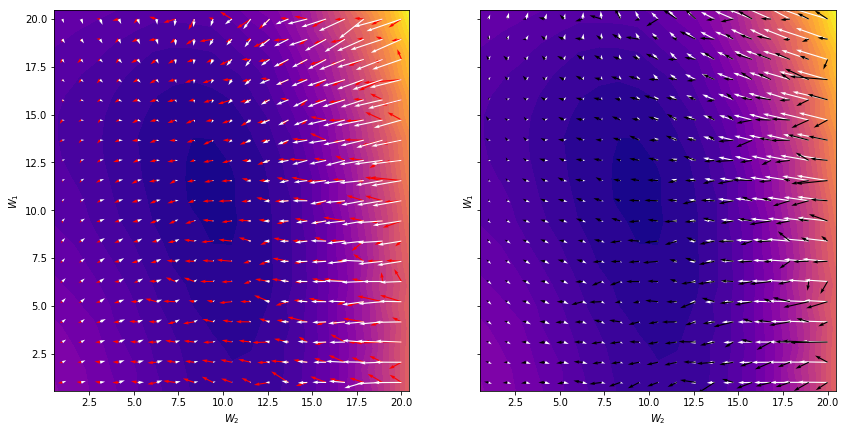

In [76]:
grad = np.gradient(cost2)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,7), sharey = True)

a=ax1.contourf(cost2, 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
ax1.quiver(X, Y, -dJ[:,:,1], -dJ[:,:,0], color=(1, 0, 0))
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
#ax1.set_title("Regression discontinuity")
ax1.set_xlabel('$W_2$')
ax1.set_ylabel('$W_1$')

a=ax2.contourf(cost2, 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax2.quiver(X, Y, -beta_theory[:,:,1], beta_theory[:,:,0], color=(1, 1, 1))
ax2.quiver(X, Y, -dJ[:,:,1], dJ[:,:,0], color=(0, 0, 0))
#ax2.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
#ax1.set_title("Regression discontinuity")
ax2.set_xlabel('$W_2$')
ax2.set_ylabel('$W_1$')

Actually in this case the correction doesn't do much. It's off by less than 10% mostly

In [78]:
err1 = 0.5*(prod(C_s1s1, sigma11_w1) + 2*prod(C_s1s2, sigma12_w1) + prod(C_s2s2, sigma22_w1))
err2 = 0.5*(prod(C_s1s1, sigma11_w2) + 2*prod(C_s1s2, sigma12_w2) + prod(C_s2s2, sigma22_w2))

errs = np.divide(np.sqrt(err1**2 + err2**2), np.sqrt(np.multiply(mu1_w1, C_s1)**2 + np.multiply(mu2_w2, C_s2)**2))

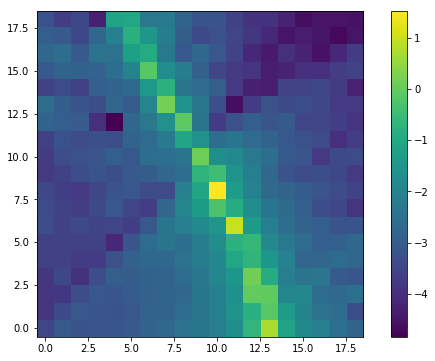

In [82]:
a = plt.imshow(np.log(errs), origin = 'lowrr')
plt.colorbar(a)

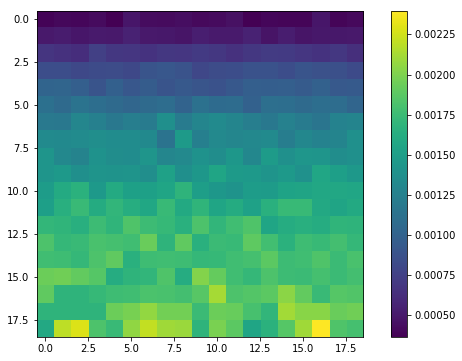

In [84]:
plt.imshow(mu1_w1)
plt.colorbar()

We should compare this to the theoretical gradient